Import Libraries needed for classification task

In [1]:
import pandas
import numpy
import seaborn
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import metrics 
import scikitplot 

In [2]:
#Hide all the warnings in jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Store result from different models
model_result = {}

We will use titanic dataset which is available on kaggle. Dataset is downloaded from https://www.kaggle.com/c/titanic. This dataset is about people on titanic. It contains some attribute and status which is survived or not.

In [4]:
#Load data in pandas dataframe
titanic_data = pandas.read_csv('./data/titanic_data.csv')

In [5]:
#Check the head of the data. 
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is the description available for features. 

PassendgerID - Unique ID of each passenger.

Survived - Passenger was survived or not. { 0 = Not Survived , 1 = Survived}

Pclass - Ticket Class. It contains 3 cateogies. {1 = Upper, 2 = Middle, 3 = Lower}

Name - Name of the passenger.

Sex - male or female.

Age - Age of the passenger.

SibSp - Number of siblings or spouses aboard the Titanic.

Parch - Number of parents or children aboard the Titanic.

Ticket - ticket number

Fare - Fare collected from passenger.

Cabin - Cabin number.

Embarked - Port of Embarkation {S = Southampton, Q = Queenstown, C = Cherbourg}

We don't need all the information above. We can keep only useful fields and drop the rest.

In [6]:
#Keep selected columns
titanic_data = titanic_data[['Survived','Pclass','Sex','Age','SibSp','Parch','Embarked','Fare']]

In [7]:
#Check new data
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare
0,0,3,male,22.0,1,0,S,7.2500
1,1,1,female,38.0,1,0,C,71.2833
2,1,3,female,26.0,0,0,S,7.9250
3,1,1,female,35.0,1,0,S,53.1000
4,0,3,male,35.0,0,0,S,8.0500


In [8]:
#Check the dimension of the data
titanic_data.shape

(891, 8)

First we check the count of survived and not survived passengers. We will use seaborn countplot for this.

In [9]:
titanic_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

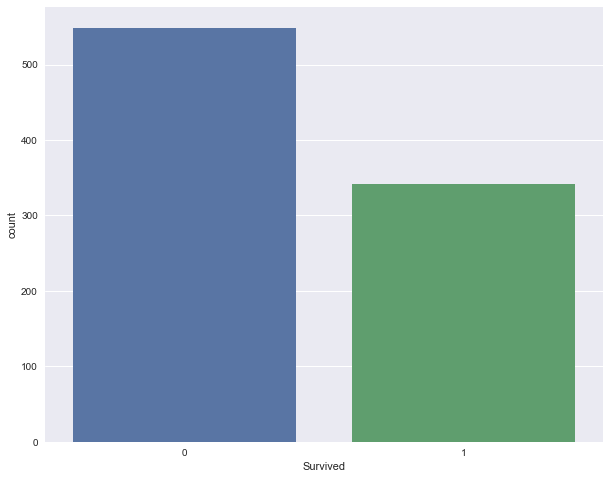

In [10]:
seaborn.countplot(x='Survived',data=titanic_data)

Before applying classification algorithm we will perform feature engineering task on the dataset. 

First we will check for any missing value in the dataset.

In [11]:
#Check if any feature contains missing value
titanic_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Embarked     True
Fare        False
dtype: bool

In [12]:
#Now check the count of null value in each feature
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
Fare          0
dtype: int64

Age is a continuous variable. It contains 177 null values. We can replace null values by different strategies. Here we are replacing null values by mean value of non-null values.

In [13]:
titanic_data['Age'].fillna((titanic_data['Age'].mean()), inplace=True)

Embarked contains two null values. We can drop these two records without impacting much on our algorithm.

In [14]:
titanic_data.dropna(inplace=True)

Now check the data type of each feature.

In [15]:
titanic_data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Embarked     object
Fare        float64
dtype: object

In [16]:
#Take dependent and independent variables separately 
titanic_data_X = titanic_data[['Pclass','Sex','Age','SibSp','Parch','Embarked','Fare']]
titanic_data_Y = titanic_data[['Survived']]

We have to perform more engineering on this dataset. Aim of our classification algorithm is to create a model that works well unseen data. So first create a test dataset and keep it separate for testing purpose.

In [17]:
#Divide the data into training and test set. train set contains 80% of the data. test set contains 20% of the data.
X_train, X_test, Y_train, Y_test = train_test_split(titanic_data_X, titanic_data_Y, test_size=0.20)

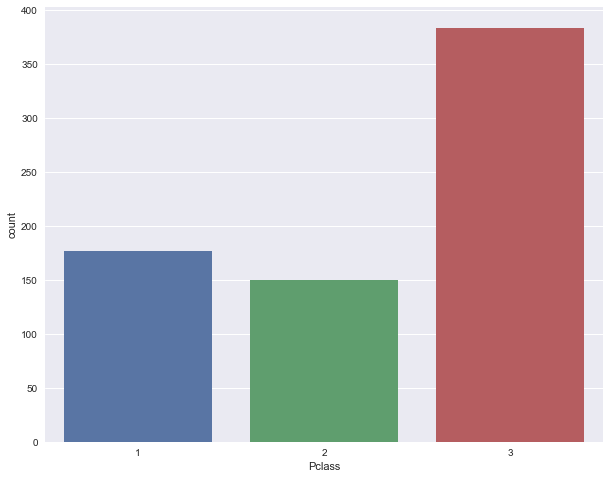

In [18]:
#Check the count of Pclass
seaborn.countplot(x='Pclass',data=X_train)

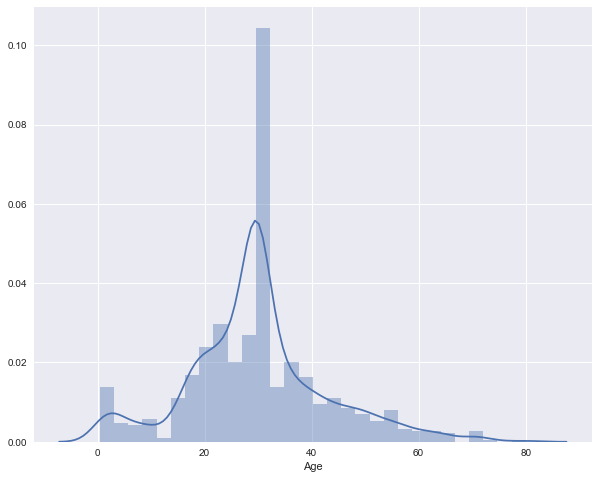

In [19]:
#Check the distribution of age data. It contains peak in histogram which is due to replacing of missing value with the mean value.
seaborn.distplot(X_train['Age'])

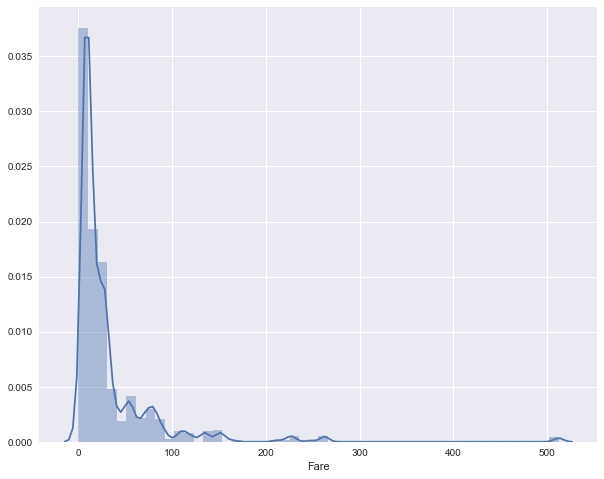

In [20]:
#Also distribution of fare.
seaborn.distplot(X_train['Fare'])

In [21]:
# We will perform Z-Score normalization on both these features. 
age_scaler = StandardScaler()
age_scaler.fit(pandas.DataFrame(X_train['Age']))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
#Transform age
X_train[['Age']] = age_scaler.transform(X_train[['Age']])

In [23]:
#Perform same normalization with Fare
fare_scaler = StandardScaler()
fare_scaler.fit(pandas.DataFrame(X_train['Fare']))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
#Transform fare
X_train[['Fare']] = fare_scaler.transform(X_train[['Fare']])

In [25]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare
427,2,female,-0.833687,0,0,S,-0.123123
426,2,female,-0.143825,1,0,S,-0.123123
680,3,female,-0.013585,0,0,Q,-0.476363
227,3,male,-0.718710,0,0,S,-0.493914
619,2,male,-0.297128,0,0,S,-0.429643


In [26]:
#Change sex feature to 0 1 value
X_train['Sex'] = X_train['Sex'].map({'female': 0, 'male': 1})

In [27]:
#Embarked has 3 categories. We can create three different variable which represents each category.
embarked_encoder = preprocessing.LabelEncoder()
embarked_encoder.fit(pandas.DataFrame(X_train['Embarked']))

LabelEncoder()

In [28]:
#Transform Embarked
X_train[['Embarked']] = embarked_encoder.transform(X_train[['Embarked']])

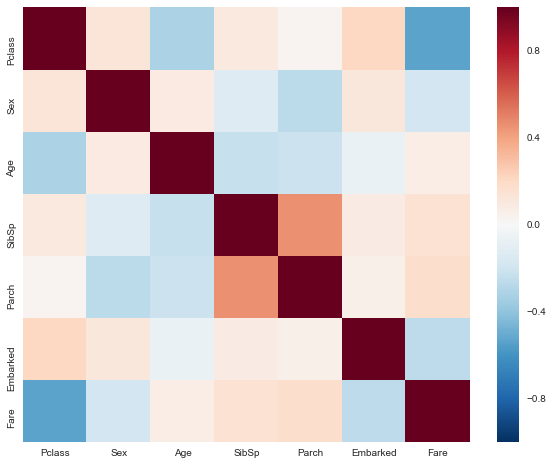

In [29]:
#Now we transform all the features in correct format. Check for correlation between features
seaborn.heatmap(X_train.corr())  

Fare and Pclass has high correlation. In logistic regression features should not be correlated. So we can remove one variable.

In [30]:
del X_train['Pclass']

Now our data is ready to apply machine learning classification algorithm. 

In [31]:
X_train_original = X_train
X_train = X_train.values
Y_train = Y_train.values

In [32]:
#Create object of logistic regression
logistic_regression = LogisticRegression()

In [33]:
#Fit the model
logistic_regression.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
#Check the coefficient of model
coefficients = pandas.concat([pandas.DataFrame(X_train_original.columns),pandas.DataFrame(numpy.transpose(logistic_regression.coef_))], axis = 1)
coefficients.columns = ['Feature','coefficient']
coefficients = coefficients.append({'Feature':'Intercept', 'coefficient':logistic_regression.intercept_[0]}, ignore_index=True)
coefficients

,Feature,coefficient
0,Sex,-2.586887
1,Age,-0.252442
2,SibSp,-0.433384
3,Parch,-0.065540
4,Embarked,-0.098265
5,Fare,0.924528
6,Intercept,1.578646


Our model is created. We can test it on our test data. But first we need to transform the test data same as we did with training data.

In [35]:
def transform_test_data(test_data,age_scaler,fare_scaler,embarked_encoder):
    test_data['Sex'] = test_data['Sex'].map({'female': 0, 'male': 1})
    test_data[['Age']] = age_scaler.transform(test_data[['Age']])
    test_data[['Fare']] = fare_scaler.transform(test_data[['Fare']])
    test_data[['Embarked']] = embarked_encoder.transform(test_data[['Embarked']])
    del test_data['Pclass']
    return test_data

In [36]:
#Apply function
X_test = transform_test_data(X_test,age_scaler,fare_scaler,embarked_encoder)

In [37]:
X_test = X_test.values
Y_test = Y_test.values

In [38]:
#Predict on test data
Y_pred = logistic_regression.predict(X_test)

In [39]:
#confusion matrix
confusion_matrix(Y_test,Y_pred)

array([[90, 26],
       [23, 39]], dtype=int64)

In [40]:
#classification report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.80      0.78      0.79       116
          1       0.60      0.63      0.61        62

avg / total       0.73      0.72      0.73       178



In [41]:
#Accuracy
print(accuracy_score(Y_test,Y_pred))

0.724719101124


Now we will plot different classification result using Scikit-plot library

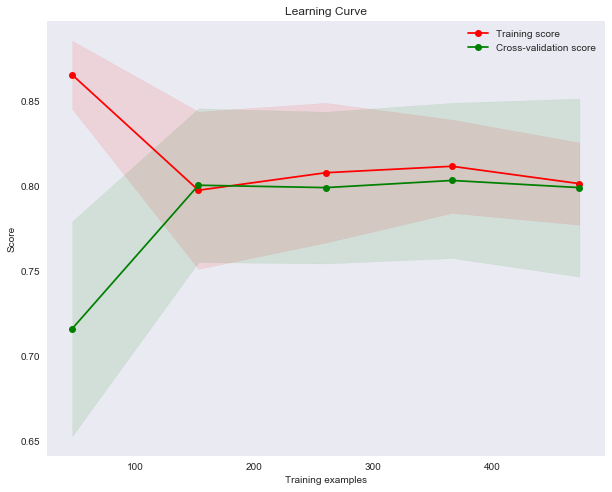

In [42]:
#We can plot learning curve of the classifier.
#It contains two separate curves. One is training curves, and another is cross validation score curve. 
#Initially Training score is high but it reduces with increasing number of example. 
#Moving towards generalized solution. CV curve has low value with less data. its score increases with higher number of training examples
scikitplot.estimators.plot_learning_curve(logistic_regression, X_train,Y_train)

In [43]:
#Predict probability instead of class in logistic regression
Y_pred_prob = logistic_regression.predict_proba(X_test)

0.780520022247


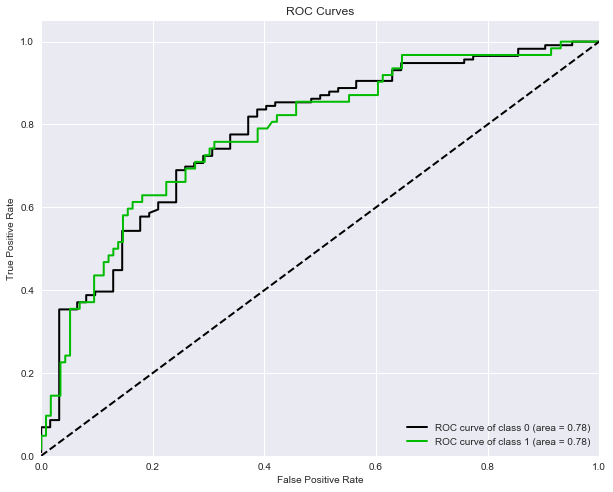

In [44]:
#ROC Curve
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Logistic Regression (L2)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

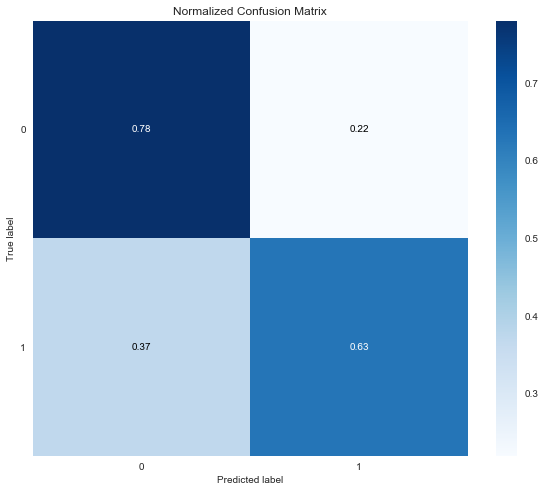

In [45]:
#Confusion Matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

In [46]:
#Fit the model with L1 norm
logistic_regression_l1 = LogisticRegression(penalty='l1',class_weight='balanced')
logistic_regression_l1.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [47]:
#Check on test data
Y_pred = logistic_regression_l1.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

0.73595505618


0.778573414905


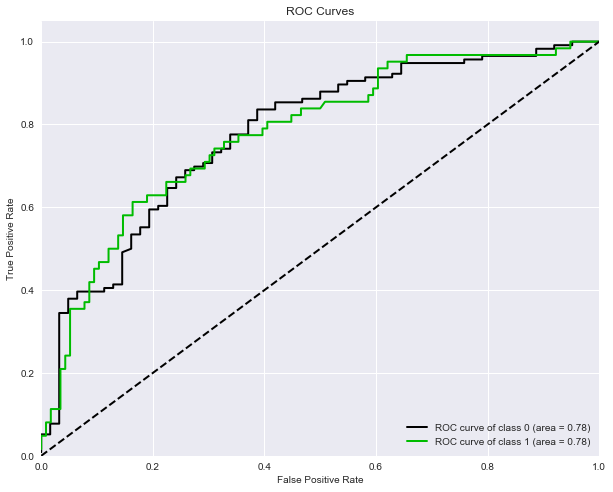

In [48]:
#ROC Curve
Y_pred_prob = logistic_regression_l1.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Logistic Regression (L1)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

## Decision Tree

We will use same data to train decision tree. We will build the model and compare performance.

In [49]:
decision_tree = tree.DecisionTreeClassifier()

In [50]:
decision_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
#Check on test data
Y_pred = decision_tree.predict(X_test)
Y_pred_prob = decision_tree.predict_proba(X_test)
print(accuracy_score(Y_test,Y_pred))

0.752808988764


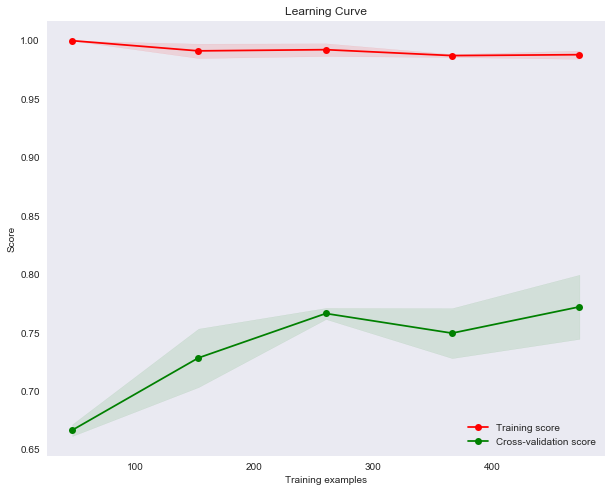

In [52]:
#Learning Curve
scikitplot.estimators.plot_learning_curve(decision_tree, X_train,Y_train)

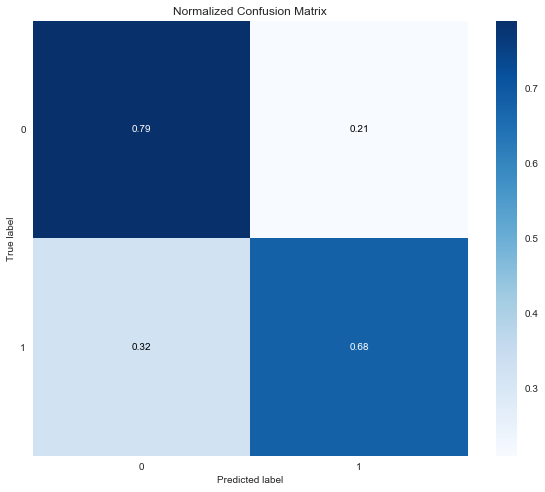

In [53]:
#Confusion matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

0.756813125695


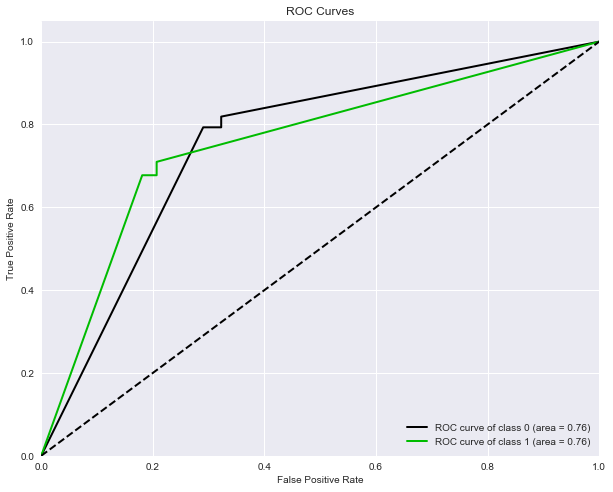

In [54]:
Y_pred_prob = decision_tree.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Decision Tree (Default)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

Decision tree improves over accuracy compare to logistic regression. When we analyse the learning curve, we can see that cross validation accuracy is not going up but training error remains high. It is because we are dealing with overfitting. One simple method is to restrict the depth of the tree. Here we choose max depth as 4.

In [83]:
decision_tree_4 = tree.DecisionTreeClassifier(max_depth=4)
decision_tree_4.fit(X_train,Y_train)

#Check on test data
Y_pred = decision_tree_4.predict(X_test)
Y_pred_prob = decision_tree_4.predict_proba(X_test)
print(accuracy_score(Y_test,Y_pred))

0.76404494382


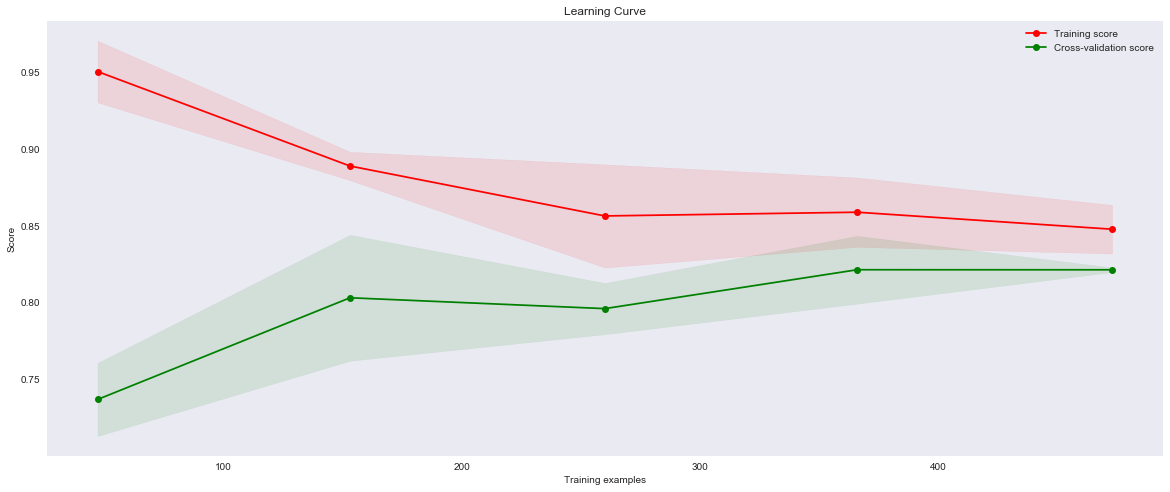

In [84]:
#Learning Curve
scikitplot.estimators.plot_learning_curve(decision_tree_4, X_train,Y_train)

This is our desirable result. Let's check confusion matrix also.

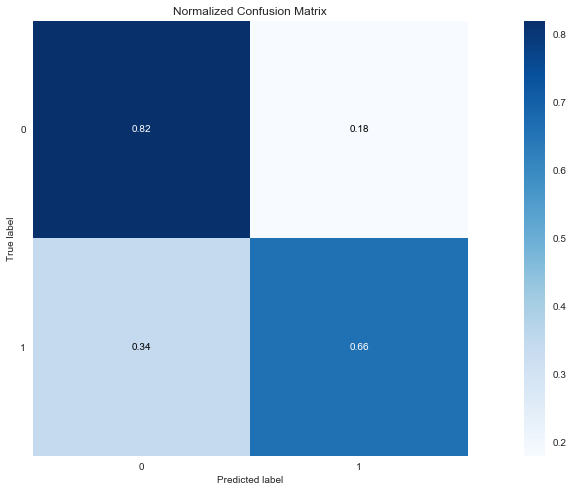

In [85]:
#Confusion matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

0.765711902113


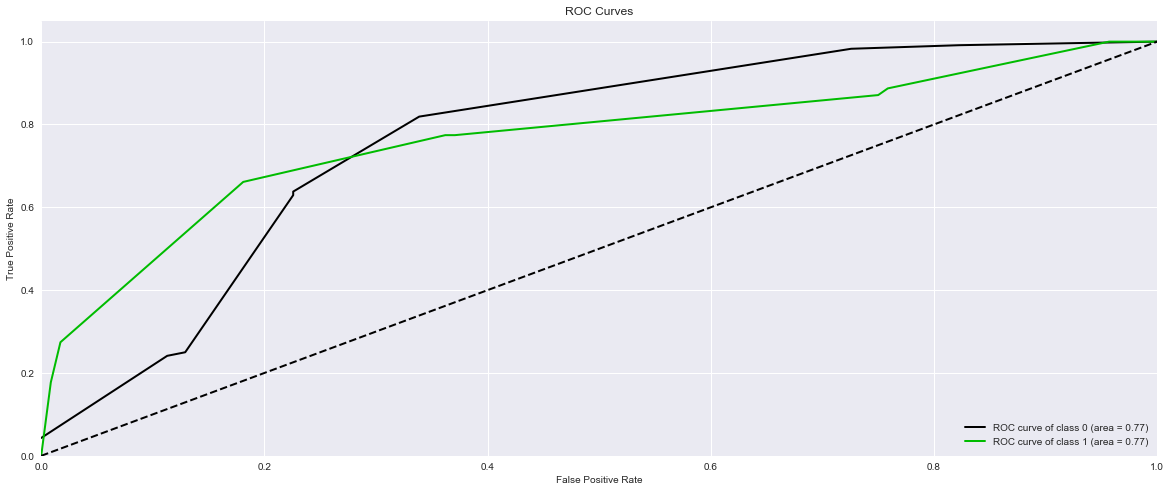

In [86]:
Y_pred_prob = decision_tree_4.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Decision Tree (Max Depth = 4)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

We can also plot the tree and visualize it. Plotting can be done using graphviz.

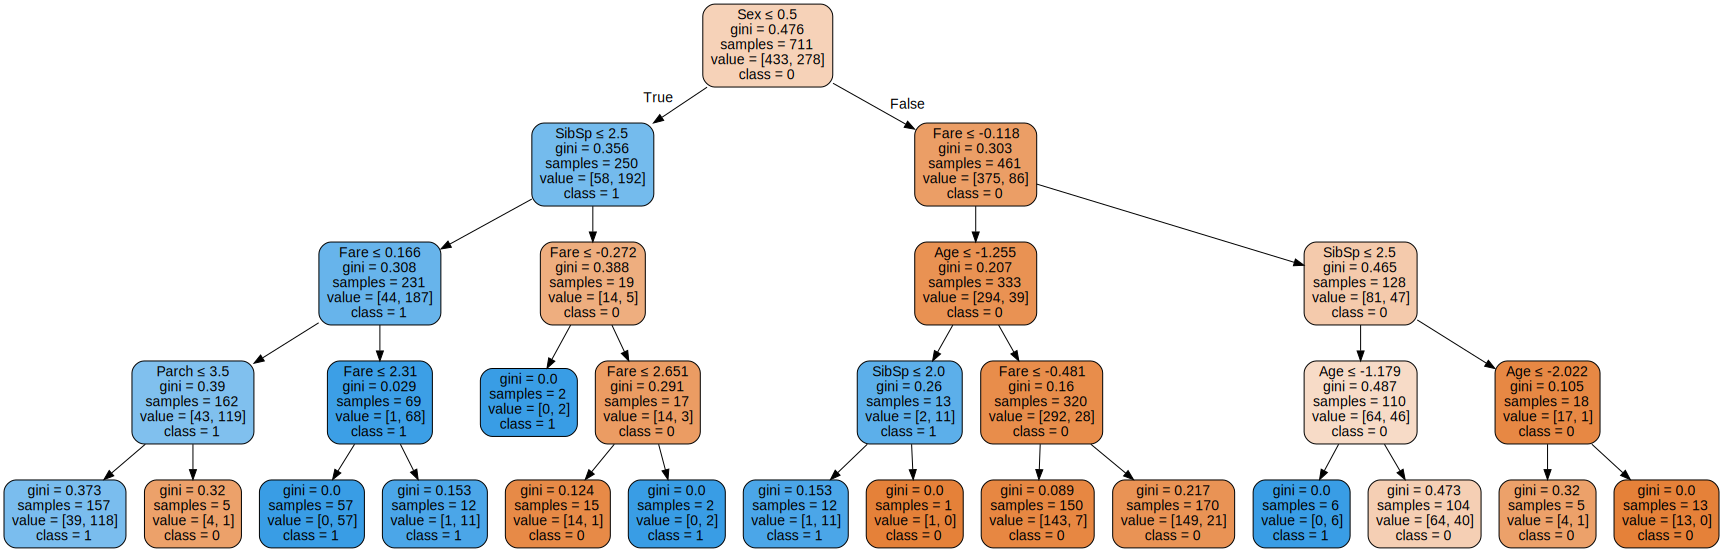

In [87]:
import graphviz 
dot_data = tree.export_graphviz(decision_tree_4, out_file=None, 
                         feature_names=X_train_original.columns,  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [88]:
# Save tree as png file.
tree.export_graphviz(decision_tree_4,out_file='tree.dot') 
!dot tree.dot -Tpng -o tree.png

## Random Forest

In [61]:
# We will build random forest on the same dataset.
random_forest = RandomForestClassifier()
random_forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
#Check on test data
Y_pred = random_forest.predict(X_test)
Y_pred_prob = random_forest.predict_proba(X_test)
print(accuracy_score(Y_test,Y_pred))

0.747191011236


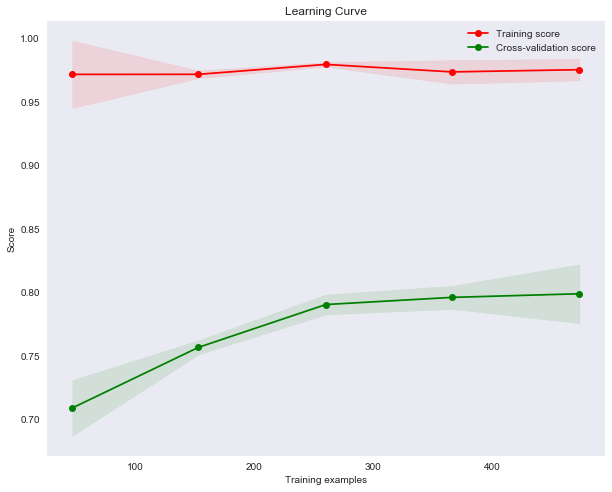

In [63]:
#Learning Curve
scikitplot.estimators.plot_learning_curve(random_forest, X_train,Y_train)

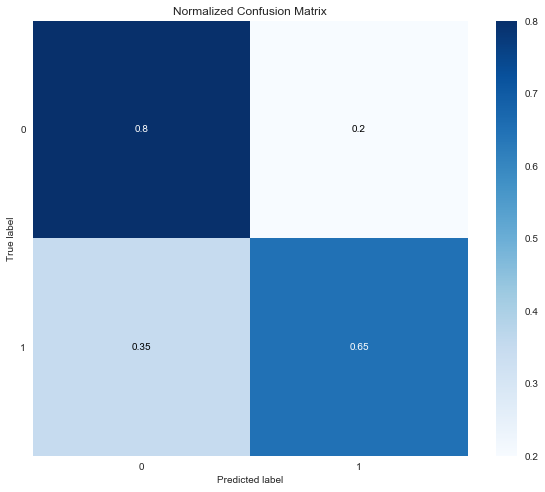

In [64]:
#Confusion matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

0.763348164627


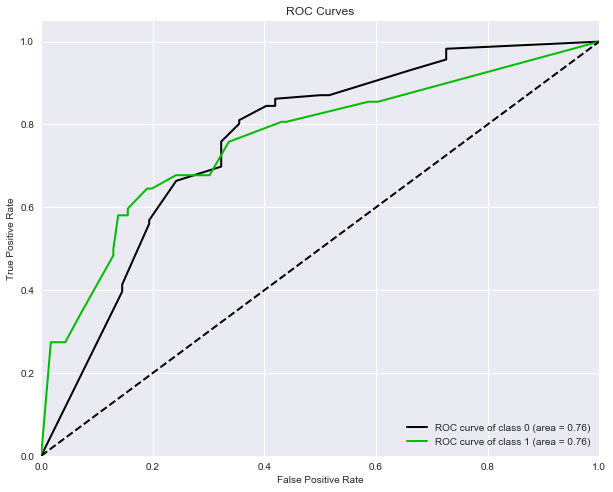

In [65]:
Y_pred_prob = random_forest.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Random Forest(Default)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

We used default parameters of random forest. We can change it and retrain the model. We will do three changes in next model building.

max_depth = 5. Each tree can go to depth 5.

n_estimators = 100. Total 100 trees are build and average prediction is taken.

max_features = 3. Maximum 3 features can be considered at one time.

In [66]:
# We will build random forest on the same dataset.
random_forest_5 = RandomForestClassifier(max_depth=5,n_estimators=100,max_features=3)
random_forest_5.fit(X_train,Y_train)

#Check on test data
Y_pred = random_forest_5.predict(X_test)
Y_pred_prob = random_forest_5.predict_proba(X_test)
print(accuracy_score(Y_test,Y_pred))

0.76404494382


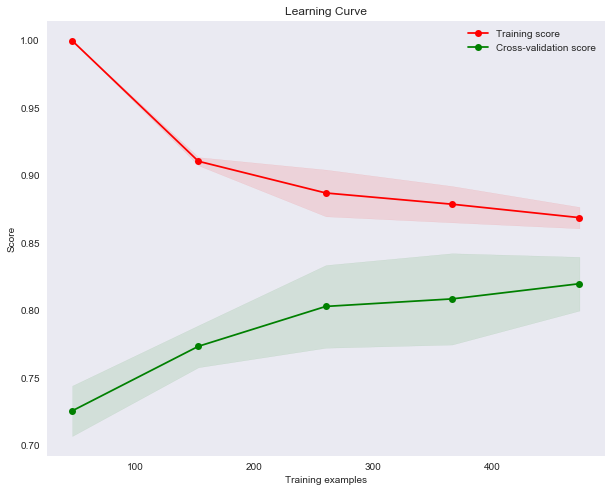

In [67]:
#Learning Curve
scikitplot.estimators.plot_learning_curve(random_forest_5, X_train,Y_train)

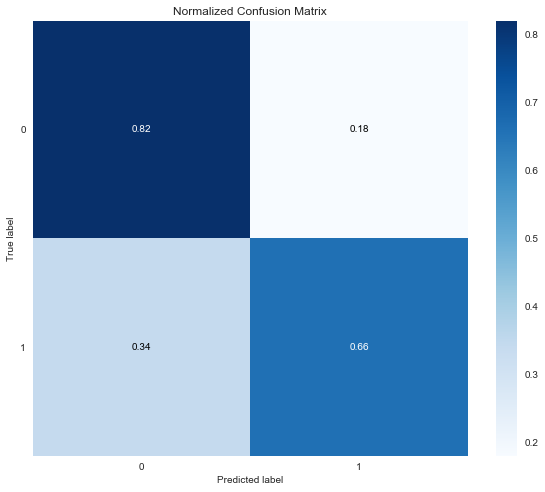

In [68]:
#Confusion matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

0.776209677419


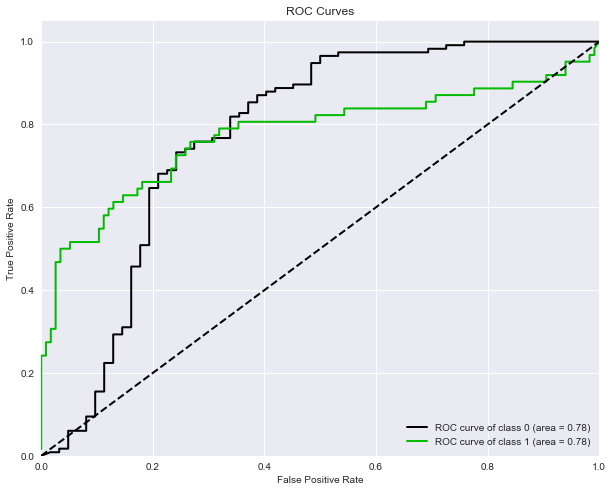

In [69]:
Y_pred_prob = random_forest_5.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Random Forest(Max Depth = 5)'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

## Naive Bayes

In [70]:
#Build the model using same data.

naive_bayes = GaussianNB()
naive_bayes.fit(X_train,Y_train)

GaussianNB(priors=None)

In [71]:
#Check on test data
Y_pred = naive_bayes.predict(X_test)
Y_pred_prob = naive_bayes.predict_proba(X_test)
print(accuracy_score(Y_test,Y_pred))

0.730337078652


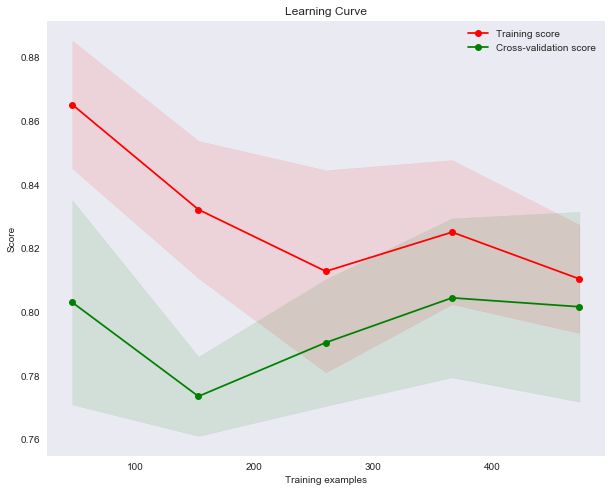

In [72]:
#Learning Curve
scikitplot.estimators.plot_learning_curve(naive_bayes, X_train,Y_train)

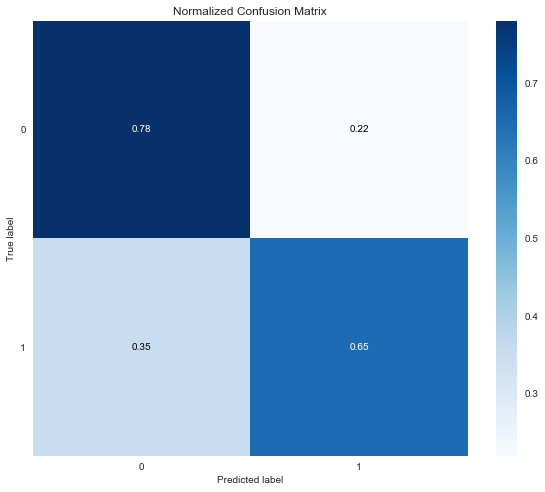

In [73]:
#Confusion matrix
scikitplot.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=True)

0.755075083426


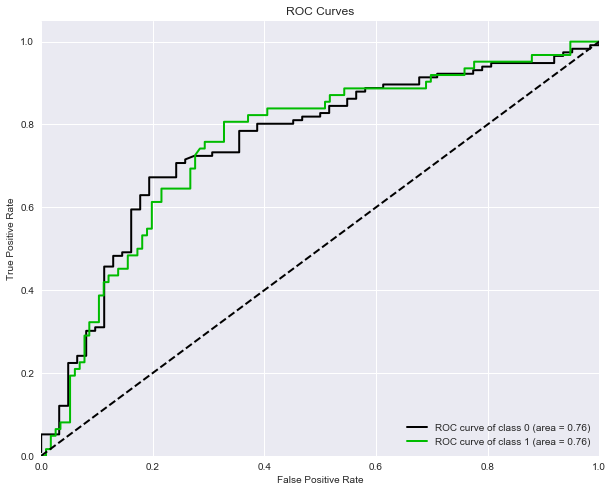

In [74]:
#ROC Curve
Y_pred_prob = naive_bayes.predict_proba(X_test)
class_1_prob = list()
for i in Y_pred_prob:
    class_1_prob.append(i[1])
print(roc_auc_score(Y_test,class_1_prob))
model_result['Naive Bayes'] = roc_auc_score(Y_test,class_1_prob)
scikitplot.metrics.plot_roc_curve(Y_test, Y_pred_prob,curves=['each_class'])

In [75]:
model_result

{'Decision Tree (Default)': 0.75681312569521697,
 'Decision Tree (Max Depth = 4)': 0.76731090100111232,
 'Logistic Regression (L1)': 0.77857341490545062,
 'Logistic Regression (L2)': 0.78052002224694106,
 'Naive Bayes': 0.75507508342602891,
 'Random Forest(Default)': 0.76334816462736366,
 'Random Forest(Max Depth = 5)': 0.77620967741935476}

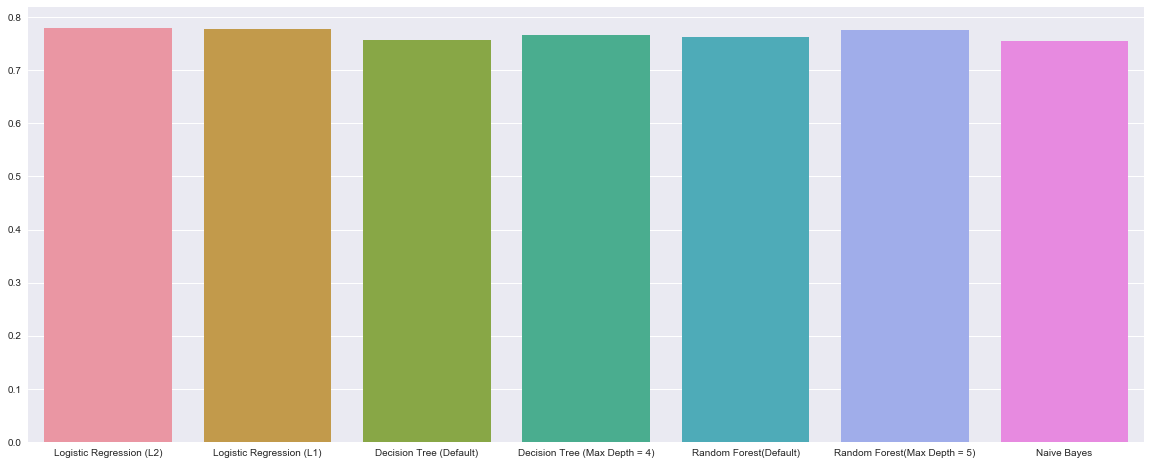

In [76]:
rcParams['figure.figsize'] = 20, 8
seaborn.barplot(x=list(model_result.keys()),y=list(model_result.values()))

From above barplot we can see decision perform less compare to logistic regression. But when we change the initial parameter setting od decision tree, results are improved. Results are further improved by random forest. Naive bayes does not perform better in this case because the features are not completely independent with each other.